<a href="https://colab.research.google.com/github/BangachevKiril/RepresentationLearningTheory/blob/main/ImageNetEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for experiments with SigLIP
by Kiril Bangachev, Guy Bresler, Iliyas Noman, and Yury Polyanskiy

The original SigLIP was developed in [this paper by Google DeepMind](https://arxiv.org/abs/2303.15343).

The experiments reflect the paper [by Bangachev, Breslr, Noman, Polyanksiy.](tbd) and use the ImageNet validation dataset.

## 0. Imports

In [ ]:
from datasets import load_dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torchvision

In [ ]:
# optional. This is toconveniently save embeddings once processed if necessary
from google.colab import drive
drive.mount('/content/drive')

## 1. Get data and preprocess

In [ ]:
!mkdir ImageNetVal

In [ ]:
# downloading imagenet data. With a fast internet and download speed of 15MB/s should take about 7 mins.
%cd ImageNetVal
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

/content/ImageNetVal
--2025-09-10 11:46:00--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6.3G) [application/x-tar]
Saving to: ‘ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6.28G  9.65MB/s    in 18m 27s 

2025-09-10 12:04:28 (5.81 MB/s) - ‘ILSVRC2012_img_val.tar’ saved [6744924160/6744924160]



In [ ]:
!mkdir val

In [ ]:
# extract
!tar -xvf ILSVRC2012_img_val.tar -C val

In [ ]:
# uses the labels_text.txt file which has a list of labels in English.
labels_lookup = []
with open('labels_text.txt', 'r') as f:
  for line in f:
    labels_lookup.append(line.split('\n')[0])

In [ ]:
# split the ImageNet dataset based on classes
import shutil

# Paths
val_dir = "val"                          # folder with 50k images
mapping_file = "labels_text.txt"         # class labels
output_dir = "val_unpacked"              # where we unpack into 998 folders (two classes have 100 instead of 50 images)

# Create output folder
os.makedirs(output_dir, exist_ok=True)

# Read mapping
with open(mapping_file, "r") as f:
    lines = f.readlines()

for i,line in enumerate(lines):
    filename = 'ILSVRC2012_val_000' +'0'*(5-len(str(i+1))) + str(i+1) + '.JPEG'
    src = os.path.join(val_dir, filename)
    dst_dir = os.path.join(output_dir, str(line.split('\n')[0]))
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, filename)
    shutil.move(src, dst)

print("Done! Validation set organized into 1000 folders.")

Done! Validation set organized into 1000 folders.


## 2. Embed

In [ ]:
# get libraries necessary for Hugging Face models
!pip install -U transformers
import requests
from transformers import AutoProcessor, AutoModel

In [ ]:
# get model and processor from Hugging Face. See https://huggingface.co/spaces?search=google/siglip-
variety = 'siglip-base-patch16-224' # This is a base model with .2B params that requires 224 x 224 images
model = AutoModel.from_pretrained("google/" + variety).to('cuda')
processor = AutoProcessor.from_pretrained("google/" + variety)

In [ ]:
# embed finally! On a single A100 should take about 6-7 mins. Can probably be reduced with larger batch sizes
# current batches are single class batches,so around 50 each. Something ike 200 may do better
dim = 768 # dimension of each mage
num = 50000 # number of images
image_embeddings = np.zeros((num, dim))
text_embeddings = np.zeros((num, dim))
splits = [] # index of first instance of each class
ordered_labels = []
folder_path = "val_unpacked"  # Use val_unpacked as the images were moved there
files_in_folder = os.listdir(folder_path)
so_far = 0
for i,label in enumerate(os.listdir('val_unpacked')):
  with torch.no_grad(): #no grad computations plz
    images = [Image.open('val_unpacked/'+label + '/' + filename ).convert('RGB') for
              filename in os.listdir('val_unpacked/'+label)] # get images
    for _ in os.listdir('val_unpacked/'+label):
      ordered_labels.append(label)
    inputs = processor(images=images, text=[label],
                       return_tensors="pt", padding="max_length").to(model.device) # process
    splits.append(so_far)
    outputs = model(**inputs) # forward pass
    #record
    image_embeddings[so_far: so_far + len(images), :] = outputs.image_embeds.detach().cpu().numpy()
    text_embeddings[so_far: so_far + len(images), :] = np.outer(
        np.ones(len(images)), outputs.text_embeds.detach().cpu().numpy())
    so_far += len(images)
  print(i, label, ordered_labels[-1]) # just to have a log that something is happening

In [ ]:
%cd ..

In [ ]:
# optional, save embedinsg in drive
splits = np.array(splits)
ordered_labels = np.array(ordered_labels)
np.savez('drive/My Drive/Research/SigLIP/imagenetval_siglip_base_patch16_224.npz',
         text = text_embeddings,
         image = image_embeddings,
         splits = splits,
         ordered_labels= ordered_labels)

## 3. Experiments

### 3.1 IP Separation
Tets that embeddinsg are nearly a constelation

In [ ]:
unique_texts = text_embeddings[splits]
unique_texts.shape

(998, 768)

In [ ]:
ips  = image_embeddings @ unique_texts.T

In [ ]:
# can certainly be optimized but 12 secs is not the worst..
matching = []
nonmatching = []
c = 0
for i in range(ips.shape[0]):
  if c+1<len(splits) and splits[c+1] == i:
    c +=1
  for j in range(ips.shape[1]):
    if c == j:
      matching.append(ips[i, j])
    else:
      nonmatching.append(ips[i,j])

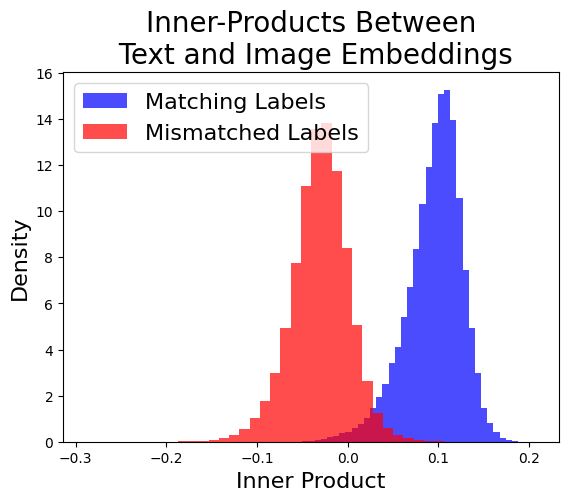

In [ ]:
# Give it a minute or two. It's histogramming 5,000,000 data points...

# Create the density histogram
plt.hist(matching, bins=40, color='blue', alpha=0.7, label='Matching Labels', density=True)
plt.hist(nonmatching, bins=40, color='red', alpha=0.7, label='Mismatched Labels', density=True)

# Customize the plot
plt.title('Inner-Products Between\n Text and Image Embeddings', fontsize = 20)
plt.xlabel('Inner Product', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.legend(fontsize = 16)

# Show the plot
plt.savefig('drive/My Drive/Research/SigLIP/figs/imagenetval_siglip_base_patch16_224_ips.png',
            bbox_inches='tight', dpi = 300)
plt.show()

### 3.2 Modality gap

In [ ]:
from sklearn.linear_model import Perceptron

In [ ]:
representations = np.concatenate([image_embeddings, text_embeddings])
modality = np.concatenate([-np.ones(image_embeddings.shape[0]), np.ones(image_embeddings.shape[0])])

In [ ]:
classifier = Perceptron(fit_intercept=True)
classifier.fit(representations,modality)

Perceptron()

In [ ]:
predicted = np.matmul(representations, classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_
predicted_text = predicted[modality == 1]
predicted_image = predicted[modality == -1]

In [ ]:
print("Misclassifed text: ",np.sum(predicted_text < 0))
print("Misclassifed images: ",np.sum(predicted_image > 0))

Misclassifed text:  0
Misclassifed images:  0


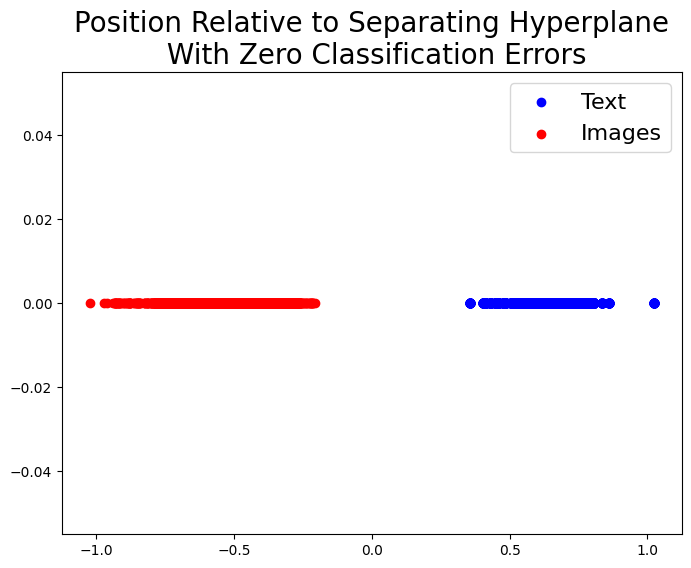

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plot class 1 data in blue
plt.scatter(predicted_text, np.zeros_like(predicted_text), color='blue', label='Text')

# Plot class 2 data in red
plt.scatter(predicted_image, np.zeros_like(predicted_image), color='red', label='Images')

# Customize the plot (optional)
plt.title('Position Relative to Separating Hyperplane\n With Zero Classification Errors', fontsize = 20)
plt.legend(fontsize = 16)

# Show the plot
plt.savefig('drive/My Drive/Research/SigLIP/figs/imagenetval_siglip_base_patch16_224_mg.png',
            bbox_inches='tight', dpi = 300)
plt.show()